In [3]:
import numpy
from matplotlib import pyplot
import ipywidgets

%matplotlib inline

In [4]:
pyplot.rc('font', family='serif', size=16)

In [5]:
def rho_red_light(x, rho_max):
    rho = numpy.full_like(x, rho_max)
#    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] /= 2
    return rho

In [53]:
# Set Parameters
nx = 81
L = 4.0
dx = L / (nx - 1)
x = numpy.linspace(0.0, L, num=nx)

nt =100

rho_max = 10.0
u_max = 1.0

sigma = 1

dt = dx * sigma / u_max

rho0 = rho_red_light(x, rho_max)

In [54]:
def plot(n, x, rho_hist):
    pyplot.figure()
    pyplot.grid()
    pyplot.title('Time step: {}'.format(n))
    pyplot.xlabel('Road [km]')
    pyplot.ylabel('Traffic density [cars/hr]')
    pyplot.plot(x, rho_hist[n])
    pyplot.xlim(x[0], x[-1])
    pyplot.ylim(4.0, 11.0)
    pyplot.show()

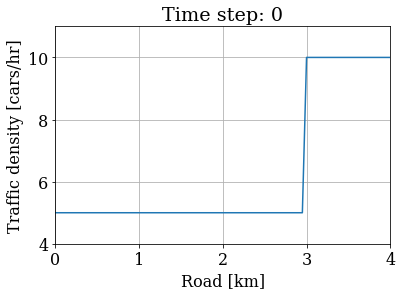

In [55]:
plot(0, x, [rho0])

In [56]:
def traffic_speed(rho, u_max, rho_max):
    return u_max * (1 - rho / rho_max)

def traffic_flux(rho, u_max, rho_max):
    return rho * traffic_speed(rho, u_max, rho_max)


In [57]:
def interactive_plot(x, rho_hist):
    nt = len(rho_hist) - 1
    nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='Time step')
    w = ipywidgets.interactive(plot, n=nt_slider, x=ipywidgets.fixed(x), rho_hist=ipywidgets.fixed(rho_hist))
    return w

In [58]:
interactive_plot(x, [rho0])

interactive(children=(IntSlider(value=0, description='Time step', max=0), Output()), _dom_classes=('widget-int…

In [69]:
def lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
#    for n in range(nt):
#        rhon = rho.copy()
#        F = traffic_flux(rhon, u_max, rho_max)
#        nx = len(rho0)
#        for i in range(1, nx - 1):
#            rho[i] = (0.5 * (rhon[i - 1] + rhon[i + 1]) - dt * (F[i + 1] - F[i - 1]) / (2 * dx))
#        rho_hist.append(rho.copy())
            
    
    for n in range(nt):
        F = traffic_flux(rho, u_max, rho_max)
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) - dt * (F[2:] - F[:-2]) / (2 * dx))
        rho_hist.append(rho.copy())
    return rho_hist
    

[array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10.]),
 array([ 5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
         5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
         5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
         5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
         5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
         5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
         5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  8.75,  8.75, 10.  , 10.  ,
        10.  , 10.  , 10.  , 10.  , 10. 

In [71]:
nt = 40
sigma = 1.0
dt = dx * sigma / u_max

rho_hist = lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max)

interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-in…

In [74]:
sigma = 0.5
dt = dx * sigma / u_max
nt = 80

rho_hist = lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max)

interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-in…

In [81]:
def traffic_jacobian(rho, u_max, rho_max):
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J

def lax_wendroff(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = traffic_flux(rho, u_max, rho_max)
        J = traffic_jacobian(rho, u_max, rho_max)
        rho[1:-1] = rho[1:-1] - (dt / (2 * dx)) * (F[2:] - F[:-2]) + (dt**2 / (4 * dx**2)) * ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) - (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2]))
        rho_hist.append(rho.copy())
    return rho_hist

In [83]:
sigma = 1
dt = dx * sigma / u_max
nt = 40

rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)

interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-in…

In [84]:
sigma = 0.5
dt = dx * sigma / u_max
nt = 80

rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)

interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-in…